In [1]:
import pickle
import glob
import fnmatch
import os
import math
import cv2
from keras.utils import np_utils
import random
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [2]:
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [3]:
def flat3d(array):  # input is 3072 lenghth of numpy array
    arr = np.array([])
    r = array[0:1024].reshape(1024,1)
    g = array[1024:2048].reshape(1024,1)
    b = array[2048:3072].reshape(1024,1)
    arr = np.concatenate((r,g,b),axis=1)
    return arr.reshape(32,32,3)

In [4]:
appended_train_data = []
appended_train_labels = []
appended_test_data = []

#Create Training set
for file in os.listdir('.'):
    if 'data_batch' in file:
        batch = unpickle(file)
        batch_data = batch[b'data']
        
        for array in batch_data:
            img = flat3d(array)
            appended_train_data.append(img)

        appended_train_labels.append(batch[b'labels'])

train_data = np.asarray(appended_train_data)
train_labels = np.asarray(appended_train_labels).flatten()

#Creating Test set
test_batch = unpickle('test_batch')
test_batch_data = test_batch[b'data']
test_labels = np.asarray(test_batch[b'labels'])

for array in test_batch_data:
    img = flat3d(array)
    appended_test_data.append(img)

test_data = np.asarray(appended_test_data)

print(train_data.shape)
print(train_labels.shape)
print(test_data.shape)
print(test_labels.shape)

(50000, 32, 32, 3)
(50000,)
(10000, 32, 32, 3)
(10000,)


In [5]:
#Load the META data
label_names = unpickle('batches.meta')[b'label_names']
num_classes = len(label_names)
print(label_names)
print(num_classes)

[b'airplane', b'automobile', b'bird', b'cat', b'deer', b'dog', b'frog', b'horse', b'ship', b'truck']
10


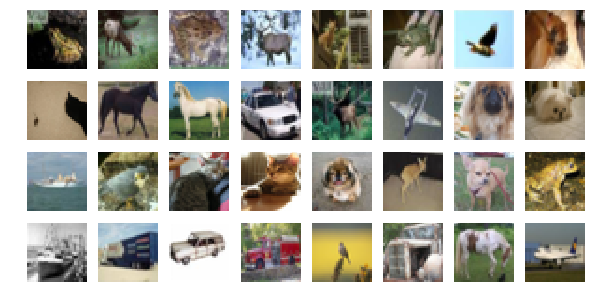

In [6]:
#Visualize random images out of the train data
nrows = 4
ncols = 8

fig, axes =plt.subplots(nrows, ncols, figsize=(10,5))

for i, ax in enumerate(axes.flat): 
    rand = random.randint(1,train_data.shape[0])
    plt.subplot(nrows, ncols, i+1)
    plt.axis('off')
    ax = plt.imshow(train_data[rand])

In [7]:
df_data = train_data[0:1000]

In [8]:

def rotate_images(X_imgs):
    X_rotate = []
    tf.reset_default_graph()
    X = tf.placeholder(tf.float32, shape = (32, 32, 3))
    k = tf.placeholder(tf.int32)
    tf_img = tf.image.rot90(X, k = k)
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for img in X_imgs:
            for i in range(3):  # Rotation at 90, 180 and 270 degrees
                rotated_img = sess.run(tf_img, feed_dict = {X: img, k: i + 1})
                X_rotate.append(rotated_img)
        
    #X_rotate = np.array(X_rotate, dtype = np.float32)
    return X_rotate

rotated_imgs = rotate_images(df_data)

Instructions for updating:
Colocations handled automatically by placer.


In [9]:
def central_scale_images(X_imgs, scales):
    # Various settings needed for Tensorflow operation
    boxes = np.zeros((len(scales), 4), dtype = np.float32)
    for index, scale in enumerate(scales):
        x1 = y1 = 0.5 - 0.5 * scale # To scale centrally
        x2 = y2 = 0.5 + 0.5 * scale
        boxes[index] = np.array([y1, x1, y2, x2], dtype = np.float32)
    box_ind = np.zeros((len(scales)), dtype = np.int32)
    crop_size = np.array([32, 32], dtype = np.int32)
    
    X_scale_data = []
    tf.reset_default_graph()
    X = tf.placeholder(tf.float32, shape = (1, 32, 32, 3))
    # Define Tensorflow operation for all scales but only one base image at a time
    tf_img = tf.image.crop_and_resize(X, boxes, box_ind, crop_size)
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        
        for img_data in X_imgs:
            batch_img = np.expand_dims(img_data, axis = 0)
            scaled_imgs = sess.run(tf_img, feed_dict = {X: batch_img})
            X_scale_data.extend(scaled_imgs)
    
    X_scale_data = np.array(X_scale_data, dtype = np.float32)
    return X_scale_data
	
# Produce each image at scaling of 90%, 75% and 60% of original image.
scaled_imgs = central_scale_images(df_data, [0.90, 0.75, 0.60])

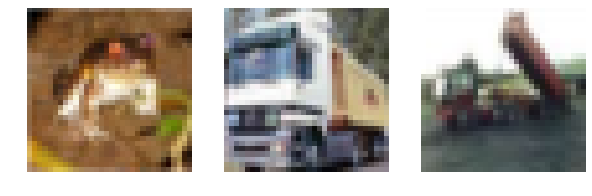

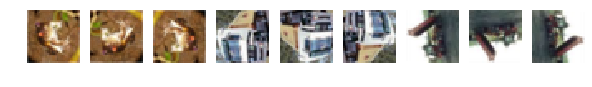

In [10]:
fig, axes = plt.subplots(1, 3, figsize=(10, 5))
for img,ax in zip(df_data[:3], axes):
    ax.imshow(img/255)
    ax.axis('off')
plt.show()
fig, axes = plt.subplots(1, 9, figsize=(10, 10))
for img,ax in zip(rotated_imgs[:9], axes):
    ax.imshow(img/255)
    ax.axis('off')
plt.show()


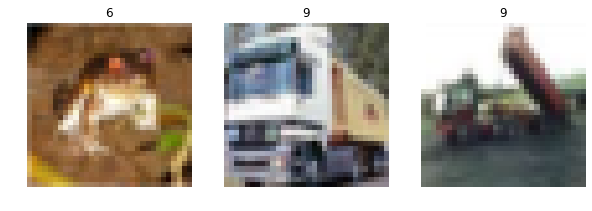

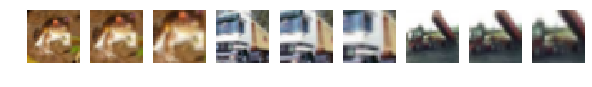

In [11]:
fig, axes = plt.subplots(1, 3, figsize=(10, 5))
for img,label,ax in zip(df_data[:3],train_labels[:3], axes):
    ax.set_title(label)
    ax.imshow(img/255)
    ax.axis('off')
plt.show()
fig, axes = plt.subplots(1, 9, figsize=(10, 10))
for img,ax in zip(scaled_imgs[:9], axes):
    ax.imshow(img/255)
    ax.axis('off')
plt.show()


In [12]:
from math import ceil, floor

def get_translate_parameters(index):
    if index == 0: # Translate left 20 percent
        offset = np.array([0.0, 0.2], dtype = np.float32)
        size = np.array([32, ceil(0.8 * 32)], dtype = np.int32)
        w_start = 0
        w_end = int(ceil(0.8 * 32))
        h_start = 0
        h_end = 32
    elif index == 1: # Translate right 20 percent
        offset = np.array([0.0, -0.2], dtype = np.float32)
        size = np.array([32, ceil(0.8 * 32)], dtype = np.int32)
        w_start = int(floor((1 - 0.8) * 32))
        w_end = 32
        h_start = 0
        h_end = 32
    elif index == 2: # Translate top 20 percent
        offset = np.array([0.2, 0.0], dtype = np.float32)
        size = np.array([ceil(0.8 * 32), 32], dtype = np.int32)
        w_start = 0
        w_end = 32
        h_start = 0
        h_end = int(ceil(0.8 * 32)) 
    else: # Translate bottom 20 percent
        offset = np.array([-0.2, 0.0], dtype = np.float32)
        size = np.array([ceil(0.8 * 32), 32], dtype = np.int32)
        w_start = 0
        w_end = 32
        h_start = int(floor((1 - 0.8) * 32))
        h_end = 32 
        
    return offset, size, w_start, w_end, h_start, h_end

def translate_images(X_imgs):
    offsets = np.zeros((len(X_imgs), 2), dtype = np.float32)
    n_translations = 4
    X_translated_arr = []
    
    tf.reset_default_graph()
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for i in range(n_translations):
            X_translated = np.zeros((len(X_imgs), 32, 32, 3), 
            dtype = np.float32)
            X_translated.fill(1.0) # Filling background color
            base_offset, size, w_start, w_end, h_start, h_end = get_translate_parameters(i)
            offsets[:, :] = base_offset 
            glimpses = tf.image.extract_glimpse(X_imgs, size, offsets)
            
            glimpses = sess.run(glimpses)
            X_translated[:, h_start: h_start + size[0], \
            w_start: w_start + size[1], :] = glimpses
            X_translated_arr.extend(X_translated)
    X_translated_arr = np.array(X_translated_arr, dtype = np.float32)
    return X_translated_arr

translated_imgs = translate_images(df_data)

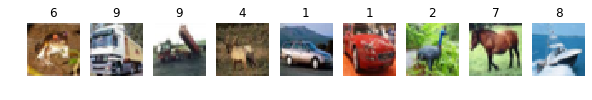

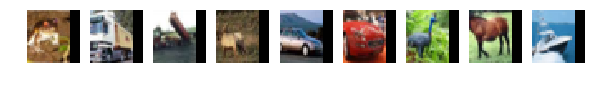

In [13]:
fig, axes = plt.subplots(1, 9, figsize=(10, 5))
for img,label,ax in zip(df_data[:9],train_labels[:9], axes):
    ax.set_title(label)
    ax.imshow(img/255)
    ax.axis('off')
plt.show()
fig, axes = plt.subplots(1, 9, figsize=(10, 10))
for img,ax in zip(translated_imgs[:9], axes):
    ax.imshow(img/255)
    ax.axis('off')
plt.show()


In [14]:
translated_imgs.shape

(4000, 32, 32, 3)

In [15]:
train_data_ = np.concatenate((train_data,translated_imgs,rotated_imgs,scaled_imgs))
train_data_.shape

(60000, 32, 32, 3)

In [16]:
# Standardize
mean_train = np.mean(train_data)
std_train = np.std(train_data)

train_data_std = (train_data-mean_train)/(std_train)
X_test = (test_data-mean_train)/(std_train)

labels_cat = np_utils.to_categorical(train_labels, num_classes)
y_test = np_utils.to_categorical(test_labels, num_classes)

In [17]:
#Split in training and validation set

X_train, X_val, y_train, y_val = train_test_split(train_data_std, labels_cat, test_size=0.1, random_state=42)

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)


(45000, 32, 32, 3)
(5000, 32, 32, 3)
(10000, 32, 32, 3)
(45000, 10)
(5000, 10)
(10000, 10)


In [18]:
#Hyperparameter
batch_size = 1000
epochs=20
lr = 0.001

In [19]:
#Placeholder
x = tf.placeholder("float", [None, 32,32,3])
y = tf.placeholder("float", [None, num_classes])

In [20]:
#Variables
hidden_layer_1 = {'wc1': tf.get_variable('W0', shape=(3,3,3,32), initializer=tf.contrib.layers.xavier_initializer()),
                  'bc1': tf.get_variable('B0', shape=(32), initializer=tf.contrib.layers.xavier_initializer())}

fully_connected = {'wd1': tf.get_variable('W3', shape=(8*8*32,32), initializer=tf.contrib.layers.xavier_initializer()),
                  'bd1': tf.get_variable('B3', shape=(32), initializer=tf.contrib.layers.xavier_initializer())}

fully_connected1 = {'wd12': tf.get_variable('W32', shape=(32,16), initializer=tf.contrib.layers.xavier_initializer()),
                  'bd12': tf.get_variable('B32', shape=(16), initializer=tf.contrib.layers.xavier_initializer())}

output_layer = {'wo': tf.get_variable('W6', shape=(16,num_classes), initializer=tf.contrib.layers.xavier_initializer()),
               'bo': tf.get_variable('B4', shape=(10), initializer=tf.contrib.layers.xavier_initializer())}


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [21]:
def conv2d(x, W, b, strides=1, name = "conv1"):
    # Conv2D wrapper, with bias and relu activation
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='SAME')
    x = tf.nn.bias_add(x, b)
    return tf.nn.selu(x)

In [22]:
# test flag for batch normalization
tst = tf.placeholder(tf.bool)
iter = tf.placeholder(tf.int32)


def batchnorm(Ylogits, is_test, iteration, offset, convolutional=False, name = 'batch_normalization'):
    exp_moving_avg = tf.train.ExponentialMovingAverage(0.999, iteration) # adding the iteration prevents from averaging across non-existing iterations
    bnepsilon = 1e-5
    if convolutional:
        mean, variance = tf.nn.moments(Ylogits, [0, 1, 2])
    else:
        mean, variance = tf.nn.moments(Ylogits, [0])
    update_moving_everages = exp_moving_avg.apply([mean, variance])
    m = tf.cond(is_test, lambda: exp_moving_avg.average(mean), lambda: mean)
    v = tf.cond(is_test, lambda: exp_moving_avg.average(variance), lambda: variance)
    Ybn = tf.nn.batch_normalization(Ylogits, m, v, offset, None, bnepsilon)
    return Ybn, update_moving_everages


In [23]:
def maxpool2d(x, k=2, name = "polling"):
    return tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, k, k, 1],padding='SAME')

In [24]:
def conv_net(x):  
    with tf.name_scope("conv1"):
        conv1 = conv2d(x, hidden_layer_1['wc1'], hidden_layer_1['bc1'], name = "conv")
        
        tf.summary.histogram("conv1_layer", conv1)
       
    with tf.name_scope("polling1"):
        conv1 = maxpool2d(conv1, k=2, name = "polling1")
        
    with tf.name_scope("batch_normalization"):
        conv1, update_ema = batchnorm(conv1, tst, iter, hidden_layer_1['bc1'],
                                       convolutional=True, name = 'batch_normalization')
    
    with tf.name_scope("polling2"):
        conv1 = maxpool2d(conv1, k=2, name = "polling2")
        
    with tf.name_scope("FCL") :
        fc1 = tf.reshape(conv1, [-1, fully_connected['wd1'].get_shape().as_list()[0]])
        fc1 = tf.add(tf.matmul(fc1, fully_connected['wd1']), fully_connected['bd1'])
        fc1 = tf.nn.selu(fc1)
        
        tf.summary.histogram("fcl_layer", fc1)
    
    with tf.name_scope("FCL2") :
        fc2 = tf.add(tf.matmul(fc1, fully_connected1['wd12']), fully_connected1['bd12'])
        fc2 = tf.nn.selu(fc2)
        
        tf.summary.histogram("fcl_layer", fc2)
        
    with tf.name_scope("outputlayer"):
        out = tf.add(tf.matmul(fc2, output_layer['wo']), output_layer['bo'])
        out = tf.nn.softmax(out)
        tf.summary.histogram("output_layer", out)
    
    return out,update_ema

In [25]:
with tf.name_scope("prediction"): 
    pred, update_ema = conv_net(x)
with tf.name_scope("cost"):
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y), name = "cost")
    tf.summary.histogram("cost", cost)
with tf.name_scope("reg_losses"):
    reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
    tf.summary.histogram("reg_losses", reg_losses)
    reg_constant = 0.01  # Choose an appropriate one.
    loss = cost + reg_constant * sum(reg_losses)
with tf.name_scope("name"):
    optimizer = tf.train.AdamOptimizer(lr, name = "optimizer").minimize(cost)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

Instructions for updating:
Use tf.cast instead.


In [26]:
#Here you check whether the index of the maximum value of the predicted image is equal to the actual labelled image. and both will be a column vector.
correct_prediction = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))

#calculate accuracy across all the given images and average them out. 
with tf.name_scope("accuracy"): 
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32),name = "accuracy")
    tf.summary.histogram("accuracy", accuracy)

In [27]:
# Initializing the variables
init = tf.global_variables_initializer()

In [28]:
saver = tf.train.Saver()

In [29]:
#short
X_train_short = X_train[0:45000]
X_val_short = X_val[0:5000] 
y_train_short = y_train[0:45000] 
y_val_short = y_val[0:5000]

In [30]:
with tf.Session() as sess:
    sess.run(init) 
    train_loss = []
    val_loss = []
    train_accuracy = []
    val_accuracy = []
    summary_writer = tf.summary.FileWriter('./Output', sess.graph)
    for epoch in range(epochs):
        for batch in range(len(X_train_short)//batch_size):
            batch_x = X_train_short[batch*batch_size:(batch+1)*batch_size]
            batch_y = y_train_short[batch*batch_size:(batch+1)*batch_size]    
            # Run optimization
                # Calculate batch loss and accuracy
            opt = sess.run(optimizer, feed_dict={x: batch_x, y: batch_y, tst : False})
            sess.run(update_ema, {x: batch_x, y: batch_y, tst: False, iter: epoch})
            
            loss, acc = sess.run([cost, accuracy], feed_dict={x: batch_x, y: batch_y, tst: False})
        print("Epoch " + str(epoch) + ", Loss= " + \
                      "{:.6f}".format(loss) + ", Training Accuracy= " + \
                      "{:.5f}".format(acc))
        print("Optimization Finished for epoch :",epoch)

        # Calculate accuracy for all 5000 validation images
        val_acc, valid_loss = sess.run([accuracy,cost], feed_dict={x: X_val_short,y : y_val_short, tst:False})
        sess.run(update_ema, {x: batch_x, y: batch_y, tst: False, iter: epoch})
        train_loss.append(loss)
        val_loss.append(valid_loss)
        train_accuracy.append(acc)
        val_accuracy.append(val_acc)
        print("Validation Accuracy:","{:.5f}".format(val_acc))
    summary_writer.close()
    #save the model
    save_path = 'Checkpoint/model.ckpt'
    saver.save(sess, save_path)
    print("Model saved in path: %s" % save_path)

Epoch 0, Loss= 2.022614, Training Accuracy= 0.44500
Optimization Finished for epoch : 0
Validation Accuracy: 0.41900
Epoch 1, Loss= 1.968433, Training Accuracy= 0.49400
Optimization Finished for epoch : 1
Validation Accuracy: 0.47120
Epoch 2, Loss= 1.934497, Training Accuracy= 0.53300
Optimization Finished for epoch : 2
Validation Accuracy: 0.49840
Epoch 3, Loss= 1.906259, Training Accuracy= 0.56100
Optimization Finished for epoch : 3
Validation Accuracy: 0.51700
Epoch 4, Loss= 1.886508, Training Accuracy= 0.57900
Optimization Finished for epoch : 4
Validation Accuracy: 0.53160
Epoch 5, Loss= 1.873229, Training Accuracy= 0.59600
Optimization Finished for epoch : 5
Validation Accuracy: 0.53780
Epoch 6, Loss= 1.863491, Training Accuracy= 0.60800
Optimization Finished for epoch : 6
Validation Accuracy: 0.54680
Epoch 7, Loss= 1.852288, Training Accuracy= 0.61800
Optimization Finished for epoch : 7
Validation Accuracy: 0.55420
Epoch 8, Loss= 1.847973, Training Accuracy= 0.62000
Optimization

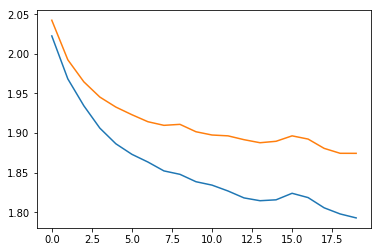

In [31]:
plt.plot(train_loss)
plt.plot(val_loss)

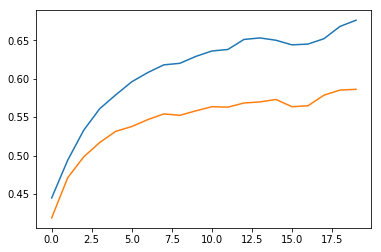

In [32]:
plt.plot(train_accuracy)
plt.plot(val_accuracy)

In [36]:
def test_neural_network(X_test, y_test):
    
    test_acc =  []
    test_correct_pred = []
    test_labels = []
    
    pred = conv_net(x)
    
    with tf.Session() as sess:
        sess.run(tf.initialize_all_variables())
        
        try:
            saver.restore(sess,"Checkpoint/model.ckpt")
            print('Restored model succesfully')
        except Exception as e:
            print(str(e))
        epoch_loss = 0
        
        #Returns the predicted label
        label = tf.argmax(pred, dimension=1)
        
        #Bool return if predicted label is equal to true label
        correct = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
        
        accuracy = tf.reduce_mean(tf.cast(correct, 'float'))
        
        #Process the test data in batches of size batch_size
        for batch in range(len(X_test)//batch_size):
            batch_x = X_test[batch*batch_size:min((batch+1)*batch_size,len(X_test))]
            batch_y = y_test[batch*batch_size:min((batch+1)*batch_size,len(y_test))]    
            
            labels = label.eval({x:batch_x, y:batch_y, tst : False})
            correct_pred = correct.eval({x:batch_x, y:batch_y, tst: False})
            acc = accuracy.eval({x:batch_x, y:batch_y, tst : False})
            
            #Append the resuts of each batch to a list
            test_labels.append(labels)
            test_correct_pred.append(correct_pred)
            test_acc.append(acc)
        
        flat_labels = np.asarray(test_labels).flatten()
        flat_pred = np.asarray(test_correct_pred).flatten()
        acc = np.mean(np.asarray(test_acc).flatten())
        
        return flat_labels, flat_pred, acc,test_acc

test accuracy is: 0.6084


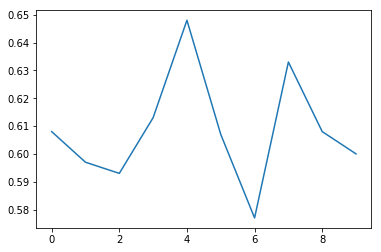

In [51]:
plt.plot(test_acc)
print("test accuracy is:",acc)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


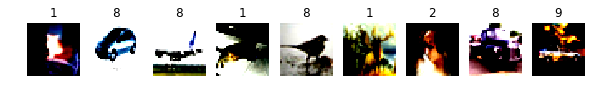

In [38]:
with tf.Session() as sesh:
    sesh.run(tf.global_variables_initializer())
    
    fig, axes = plt.subplots(1, 9, figsize=(10, 10))
    for img,ax in zip(X_train[:9], axes):
        guess = np.argmax(sesh.run(pred, feed_dict={x: [img],tst:False}))
        ax.set_title(guess)
        ax.imshow(img)
        ax.axis('off')
    plt.show()
